In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyarrow (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyarrow
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pyarrow)


In [4]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("ylecun/mnist", split="train")
dataset = dataset.shuffle(42).select(range(10000))

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

X shape: torch.Size([8, 1, 32, 32])


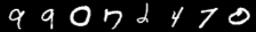

In [6]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 32, 32))

In [7]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Noisy X shape torch.Size([8, 1, 32, 32])


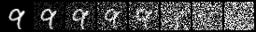

In [19]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
xb = xb[0:1].repeat(8, 1, 1, 1).to(device)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 32, 32))
#show_images(noise).resize((8 * 32, 32))

In [10]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 32, 32, 32),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [33]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape
print(timesteps)

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')


In [13]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.037367631663467474
Epoch:10, loss: 0.034288565586706635
Epoch:15, loss: 0.033379468521115126
Epoch:20, loss: 0.032138836801431744
Epoch:25, loss: 0.03104037727425053
Epoch:30, loss: 0.0302371844578131


In [30]:
# Random starting point (8 random images):
sample = noisy_xb
show_images(sample)

for i, t in enumerate(noise_scheduler.timesteps):
    print(f"Timestep {i}:")
    show_images(t)

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

#show_images(sample)

Timestep 0:


IndexError: Dimension specified as 0 but tensor has no dimensions

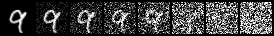

In [52]:
sample = noisy_xb
show_images(sample)

Iteration 0 (Timestep 0):


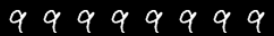

In [54]:
# 1. Start with random noise
image = noisy_xb[0:1].repeat(8, 1, 1, 1).to(device)

# 2. Loop through timesteps
for i, t in enumerate(noise_scheduler.timesteps):

    # Predict the noise with your model
    with torch.no_grad():
        noise_pred = model(image, t).sample

    # Compute the slightly cleaner image for the next step
    image = noise_scheduler.step(noise_pred, t, image).prev_sample

    # 3. Only print every 100 steps (otherwise it's too much data!)
    if i % 100 == 0 or i == len(noise_scheduler.timesteps) - 1:
        print(f"Iteration {i} (Timestep {t.item()}):")
        # Now we pass 'image', which is a Tensor, to show_images
        display(show_images(image))

In [55]:
!pip install genaibook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.4 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [56]:
from genaibook.core import show_images

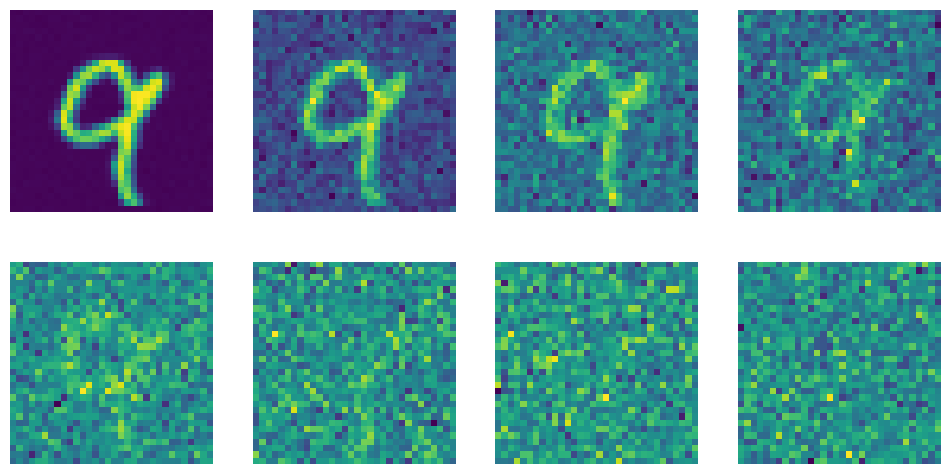

In [59]:
show_images(sample)

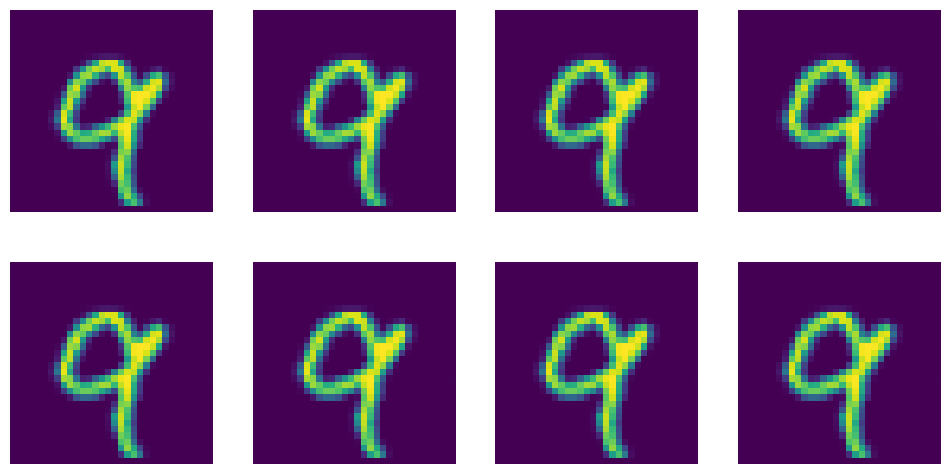

In [62]:
show_images(image)

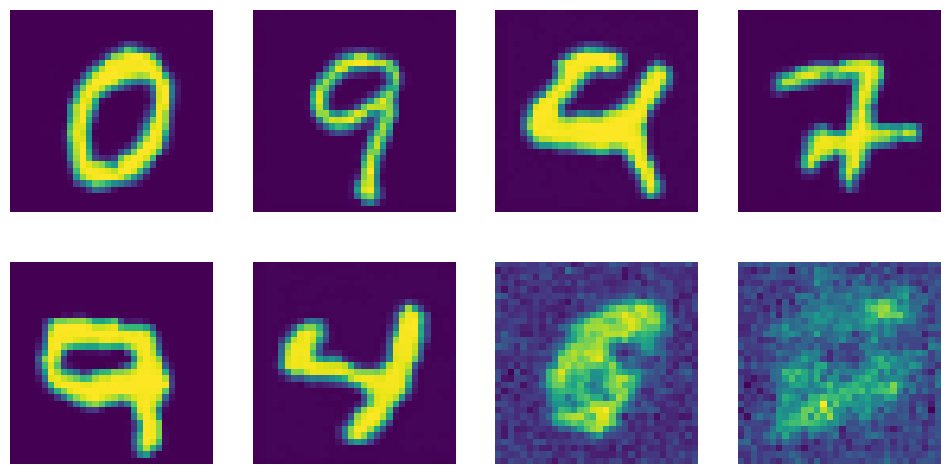

In [64]:
# Create a copy to work on
current_images = noisy_xb.clone()

# The scheduler needs to know the full range of steps
noise_scheduler.set_timesteps(100)

# We loop backwards from 999 to 0
for t in (noise_scheduler.timesteps):
    with torch.no_grad():
        # 1. Predict the noise for the current state of all 8 images
        # The model uses 't' to understand how much noise it's looking at
        noise_pred = model(current_images, t).sample

        # 2. Update the images: remove a tiny bit of noise
        # This function calculates: Image_{t-1} = f(Image_t, noise_pred)
        current_images = noise_scheduler.step(noise_pred, t, current_images).prev_sample

# All 8 images in current_images should now look like the original clean digit
show_images(current_images)

In [16]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [67]:
pipeline_output = image_pipe()
pipeline_output.images[0]
for i in range(4):
    image = pipeline_output.images[0]
    show_images(image)

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: object of type 'Image' has no len()

  0%|          | 0/1000 [00:00<?, ?it/s]

None

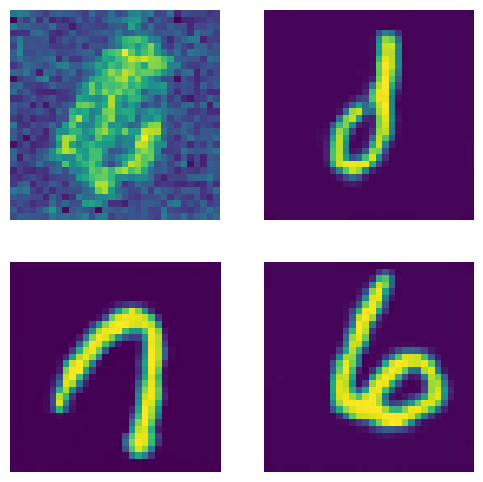

In [68]:
# 1. Tell the pipeline to generate 4 images and return them as Tensors
# We use output_type="latent" or "pt" to get Tensors instead of PIL images
pipeline_output = image_pipe(batch_size=4, output_type="pt")

# 2. Get the tensor batch [4, 1, 32, 32]
images = pipeline_output.images

# 3. Use your existing show_images function (it handles the grid and PIL conversion)
grid_result = show_images(images)

# 4. Display the final grid
display(grid_result)